# Exporting Cloud-Optimised GeoTIFFs <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)

## Background

At the end of an analysis it can be useful to export data to a GeoTIFF file (e.g. `outputname.tif`), either to save results or to allow for exploring results in a GIS software platform (e.g. ArcGIS or QGIS).

A `Cloud Optimized GeoTIFF (COG)` is a regular GeoTIFF file, aimed at being hosted on a HTTP file server, with an internal organization that enables more efficient workflows on the cloud. 

## Description

This notebook shows a number of ways to export a GeoTIFF file:

1. Exporting a single-band, single time-slice GeoTIFF from an xarray object loaded through a `dc.load` query
2. Exporting a multi-band, single time-slice GeoTIFF from an xarray object loaded through a `dc.load` query
3. Exporting multiple GeoTIFFs, one for each time-slice of an xarray object loaded through a `dc.load` query
4. Exporting data from lazily loaded `dask arrays`

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import sys
import datacube
from datacube.utils.cog import write_cog

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_plotting import rgb


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Exporting_GeoTIFFs')


## Load Landsat 8 data from the datacube

Here we are loading in a timeseries of `Landsat 8` satellite images through the datacube API.
This will provide us with some data to work with.

In [3]:
lat, lon = 13.94, -16.54
buffer = 0.05

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2017-11', '2017-12'),
    'resolution': (-30, 30),
    'measurements': ['red', 'green', 'blue'],
    'output_crs':'EPSG:6933'
}

# Load available data from Landsat 8 and filter to retain only times
# with at least 50% good data
ds = load_ard(dc=dc, 
              products=['ls8_usgs_sr_scene'], 
              **query)

# Print output data
print(ds)


Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Loading 10 time steps
<xarray.Dataset>
Dimensions:      (time: 10, x: 322, y: 414)
Coordinates:
  * y            (y) float64 1.768e+06 1.767e+06 ... 1.755e+06 1.755e+06
  * time         (time) datetime64[ns] 2017-11-06T11:21:58.372631 ... 2017-12...
    spatial_ref  int32 6933
  * x            (x) float64 -1.601e+06 -1.601e+06 ... -1.591e+06 -1.591e+06
Data variables:
    red          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### Plot an rgb image to confirm we have data

The white regions are cloud cover.

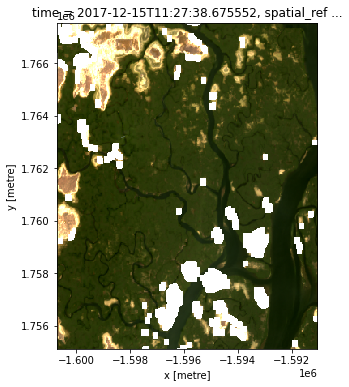

In [4]:
rgb(ds, index=5)


### Export a single-band, single time-slice GeoTIFF

This method uses the `datacube.utils.cog` function [write_cog](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.utils.cog.write_cog.html), where cog stands for [Cloud-Optimised-Geotiff](https://www.cogeo.org/) to export a simple single-band, single time-slice COG. 

A few important caveats should be noted when using this function:
1. It requires an `xarray.DataArray`; supplying an `xarray.Dataset` will return an error. To convert a `xarray.Dataset` to an array run the following: 

        da = ds.to_array()

2. This function generates a temporary in-memory tiff file without compression.  This means the function will use about 1.5 to 2 times the memory required using the depreciated `datacube.helper.write_geotiff`.

3. If you pass a `dask array` into the function, `write_cog` will not output a geotiff, but will instead return a` Dask Delayed` object. To trigger the output of the geotiff run `.compute()` on the dask delayed object: 

        write_cog(ds.red.isel(time=0), "red.tif").compute()

In [5]:
# Select a single time-slice and a single band from the dataset.
singleBandtiff = ds.red.isel(time=5)

# Write GeoTIFF to a location
write_cog(singleBandtiff,
          fname="red_band.tif",
          overwrite=True)


PosixPath('red_band.tif')

### Export a multi-band, single time-slice GeoTIFF

Here we select a single time and export all the bands in the dataset using the `datacube.utils.cog.write_cog` function.

In [6]:
# Select a single time-slice
rgb_tiff = ds.isel(time=5).to_array()

# Write multi-band GeoTIFF to a location
write_cog(rgb_tiff,
          fname='rgb.tif',
          overwrite=True)


PosixPath('rgb.tif')

### Export multiple GeoTIFFs, one for each time-slice of an xarray

If we want to export all of the time steps in a dataset as a GeoTIFF, we can wrap our `write_cog` function in a for-loop.

In [7]:
for i in range(len(ds.time)):

    # We will use the date of the satellite image to name the GeoTIFF
    date = ds.isel(time=i).time.dt.strftime('%Y-%m-%d').data
    print(f'Writing {date}')
    
    # Convert current time step into a `xarray.DataArray`
    singleTimestamp = ds.isel(time=i).to_array()

    # Write GeoTIFF  
    write_cog(singleTimestamp,
              fname=f'{date}.tif',
              overwrite=True)


Writing 2017-11-06
Writing 2017-11-13
Writing 2017-11-13
Writing 2017-11-29
Writing 2017-11-29
Writing 2017-12-15
Writing 2017-12-15
Writing 2017-12-24
Writing 2017-12-31
Writing 2017-12-31


## Advanced


### Exporting GeoTIFFs from a dask array

If you pass a lazily-loaded dask array into the function, `write_cog` will not immediately output a GeoTIFF, but will instead return a `dask.delayed` object:

In [8]:
# Lazily load data using dask
ds_dask = dc.load(product='ls8_usgs_sr_scene', 
                  dask_chunks={},
                  **query)

# Run `write_cog`
ds_delayed = write_cog(geo_im=ds_dask.isel(time=5).to_array(), 
                       fname='dask_geotiff.tif',
                       overwrite=True)

# Print dask.delayed object
print(ds_delayed)

Delayed('_write_cog-38ace11f-eaba-4984-9db4-b58dfd04f319')


To trigger the GeoTIFF to be exported to file, run `.compute()` on the `dask.delayed` object. The file will now appear in the file browser to the left.

In [9]:
ds_delayed.compute()

PosixPath('dask_geotiff.tif')

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** September 2020

**Compatible datacube version:** 

In [10]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()